In [1]:
# load in the necessary packages

from goes2go import GOES
import pandas as pd
from datetime import datetime
import xarray as xr
import subprocess
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import os

i am going to load in the GOES data first

In [2]:
# load in the datasets

import xarray as xr

# Directory containing NetCDF files
data_dir = "/glade/work/adhall/Data/GOES_DATA/ProcessGOESData/RemappedNetCDF/"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".nc")]

# Load all NetCDF files into a single xarray Dataset
combined_dataset_goes = xr.open_mfdataset(
    files,
    combine='by_coords'  # Aligns by coordinates (time, lat, lon)
)


/glade/u/home/adhall/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Could not load the ecCodes library!
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
combined_dataset_goes

<xarray.Dataset> Size: 5MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables:
    CloudImagery         (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    CloudTopTemperature  (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    DownwardSW           (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    ReflectedSW          (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
    TotalPrecipWater     (time, latitude, longitude) float64 797kB dask.array<chunksize=(30, 41, 81), meta=np.ndarray>
Attributes:
    title:        Cloud Imagery Remapped
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

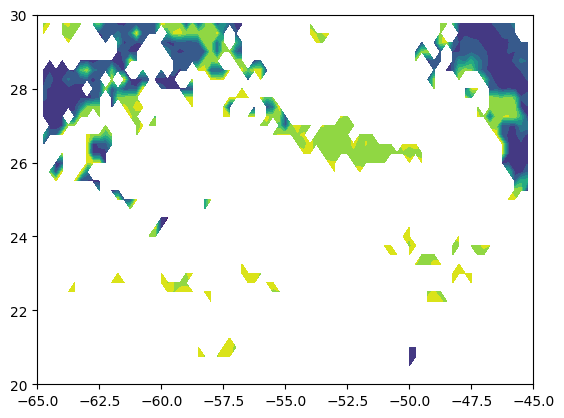

In [4]:
plt.contourf(combined_dataset_goes.longitude.values, combined_dataset_goes.latitude.values, combined_dataset_goes.CloudTopTemperature[0,:,:].values)

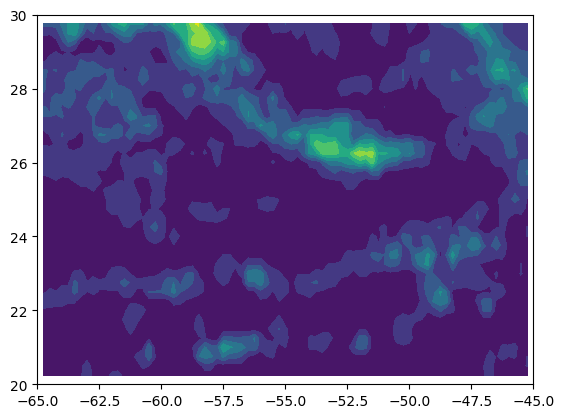

In [5]:
plt.contourf(combined_dataset_goes.longitude.values, combined_dataset_goes.latitude.values, combined_dataset_goes.ReflectedSW[0,:,:].values)

slay what a success

now era5 data

In [6]:
# get the era5 data as well

dir = "/glade/derecho/scratch/adhall/"

# Load your dataset
ds_era5 = xr.open_dataset(dir + "era5_single_levels.nc")

# 1. Subset the dataset for April 2020
ds_era5_april_2020 = ds_era5.sel(
    valid_time=(ds_era5['valid_time.year'] == 2020) & (ds_era5['valid_time.month'] == 4)
)

# 2. Subset for the time 15:00 UTC
ds_era5_april_2020_1500 = ds_era5_april_2020.sel(
    valid_time=ds_era5_april_2020['valid_time'].dt.hour == 15
)


another success! so far so good

i need to convert the times for era5 to julian days 92-121 now

In [7]:
# Create the Julian days for April 2020 (92 to 121)
date_range = pd.date_range("2020-04-01", "2020-04-30", freq="D")
julian_days = [date.dayofyear for date in date_range]  # Getting Julian days 92 to 121

# Create a new 'time' variable with Julian days
ds_era5_april_2020_1500.coords['time'] = ('valid_time', julian_days)

# Now, we can drop the 'valid_time' dimension and rename the new 'time' dimension
ds_era5_april_2020_1500 = ds_era5_april_2020_1500.drop('valid_time')

# Now, all variables will have 'time', 'lat', and 'lon' dimensions
ds_era5_april_2020_1500 = ds_era5_april_2020_1500.rename({'valid_time': 'time'})

/glade/derecho/scratch/adhall/tmp/ipykernel_24545/3298746871.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_era5_april_2020_1500 = ds_era5_april_2020_1500.drop('valid_time')
/glade/derecho/scratch/adhall/tmp/ipykernel_24545/3298746871.py:12: UserWarning: rename 'valid_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds_era5_april_2020_1500 = ds_era5_april_2020_1500.rename({'valid_time': 'time'})


In [8]:
ds_era5_april_2020_1500

<xarray.Dataset> Size: 4MB
Dimensions:    (latitude: 41, longitude: 81, time: 30)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 328B 30.0 29.75 29.5 29.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 648B -65.0 -64.75 -64.5 ... -45.25 -45.0
    expver     (time) <U4 480B ...
    time       (time) int64 240B 92 93 94 95 96 97 ... 116 117 118 119 120 121
Data variables:
    u10        (time, latitude, longitude) float32 399kB ...
    v10        (time, latitude, longitude) float32 399kB ...
    t2m        (time, latitude, longitude) float32 399kB ...
    sst        (time, latitude, longitude) float32 399kB ...
    slhf       (time, latitude, longitude) float32 399kB ...
    sshf       (time, latitude, longitude) float32 399kB ...
    hcc        (time, latitude, longitude) float32 399kB ...
    lcc        (time, latitude, longitude) float32 399kB ...
    tcc        (time, latitude, longitude) float32 399kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-20T20:22 GRIB to CDM+CF via cfgrib-0.9.1...

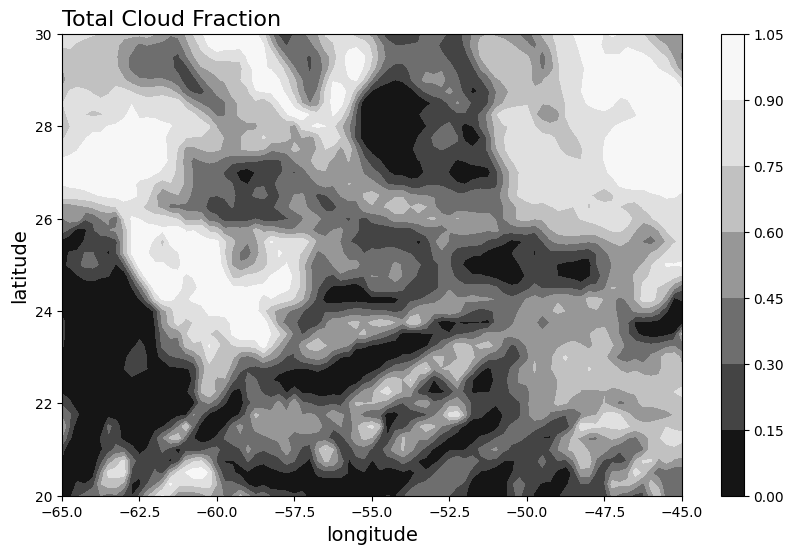

In [9]:
# plot the tcc
plt.figure(figsize=(10, 6))
plt.contourf(ds_era5_april_2020_1500.longitude.values, ds_era5_april_2020_1500.latitude.values, ds_era5_april_2020_1500.tcc[0,:,:].values, cmap='Greys_r')
plt.title("Total Cloud Fraction", loc='left', fontsize=16)
plt.ylabel("latitude", fontsize=14)
plt.xlabel("longitude", fontsize=14)
plt.colorbar()

In [10]:
# Apply the thresholding operation to create binary values
ds_era5_april_2020_1500['tcc'] = (ds_era5_april_2020_1500['tcc'] >= 0.5).astype("int8")  # Use "int8" for compact integer storage

print("Binary conversion applied. The dataset has been updated.")

Binary conversion applied. The dataset has been updated.


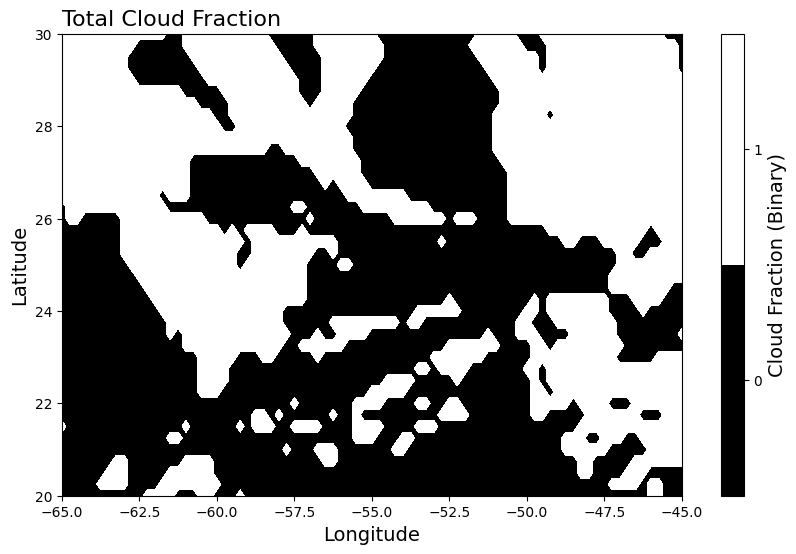

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define a binary colormap (black for 0, white for 1)
binary_cmap = mcolors.ListedColormap(['black', 'white'])

# Plot the binary 'tcc' field
plt.figure(figsize=(10, 6))
plt.contourf(
    ds_era5_april_2020_1500.longitude.values, 
    ds_era5_april_2020_1500.latitude.values, 
    ds_era5_april_2020_1500.tcc[0, :, :].values, 
    levels=[-0.5, 0.5, 1.5],  # Define levels to ensure binary separation
    cmap=binary_cmap
)

# Add title and labels
plt.title("Total Cloud Fraction", loc='left', fontsize=16)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

# Add a discrete colorbar
colorbar = plt.colorbar(ticks=[0, 1])  # Colorbar with ticks for 0 and 1
colorbar.set_label("Cloud Fraction (Binary)", fontsize=14)

plt.show()


another success

now we have to fill in the missing data in the goes dataset with bilinear interpolation

In [12]:
import numpy as np
from scipy.interpolate import griddata

def fill_nans_with_interpolation(ds):
    """
    Fill NaN values in the dataset using bilinear interpolation and nearest-neighbor fallback.
    """
    lat = ds.latitude.values
    lon = ds.longitude.values
    lon_flat, lat_flat = np.meshgrid(lon, lat)
    lon_flat = lon_flat.flatten()
    lat_flat = lat_flat.flatten()
    points = np.column_stack((lat_flat, lon_flat))

    for var_name in ds.data_vars:
        data = ds[var_name].values
        for time_index in range(data.shape[0]):  # Assuming time is the first dimension
            data_slice = data[time_index, :, :]
            mask = ~np.isnan(data_slice)
            valid_points = points[mask.flatten()]
            valid_values = data_slice[mask]

            # Bilinear interpolation for initial pass
            interpolated_data = griddata(valid_points, valid_values, points, method='linear')

            # Replace NaNs with bilinear interpolation
            data[time_index, :, :] = interpolated_data.reshape(data_slice.shape)

            # Fallback for remaining NaNs using nearest-neighbor interpolation
            if np.isnan(data_slice).any():
                fallback_data = griddata(valid_points, valid_values, points, method='nearest')
                fallback_data = fallback_data.reshape(data_slice.shape)
                data[time_index, :, :] = np.where(np.isnan(data[time_index, :, :]), fallback_data, data[time_index, :, :])
        
        # Update the dataset
        ds[var_name].values = data

    return ds

# Apply the function to your dataset
combined_dataset_goes_filled = fill_nans_with_interpolation(combined_dataset_goes)


In [13]:
combined_dataset_goes_filled

<xarray.Dataset> Size: 5MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables:
    CloudImagery         (time, latitude, longitude) float64 797kB 0.2423 ......
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
Attributes:
    title:        Cloud Imagery Remapped
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

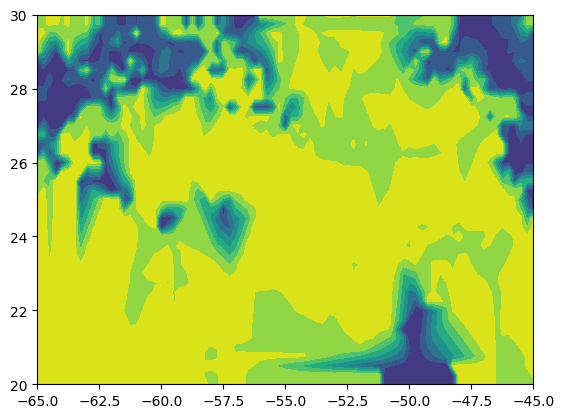

In [14]:
plt.contourf(combined_dataset_goes_filled.longitude.values, combined_dataset_goes_filled.latitude.values, combined_dataset_goes_filled.CloudTopTemperature[0,:,:].values)

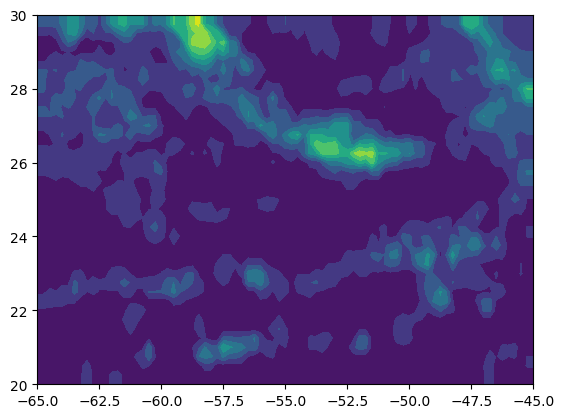

In [15]:
plt.contourf(combined_dataset_goes_filled.longitude.values, combined_dataset_goes_filled.latitude.values, combined_dataset_goes_filled.ReflectedSW[0,:,:].values)

it apppears to have worked

there is some missing edges for temperature, not sure what this is about but such is life

now we combine the two datasets

In [16]:
combined_dataset = xr.merge([combined_dataset_goes_filled, ds_era5_april_2020_1500])

In [17]:
combined_dataset

<xarray.Dataset> Size: 8MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
    number               int64 8B ...
    expver               (time) <U4 480B ...
Data variables: (12/15)
    CloudImagery         (time, latitude, longitude) float64 797kB 0.2423 ......
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
    ...                   ...
    sst                  (time, latitude, longitude) float32 399kB ...
    slhf                 (time, latitude, longitude) float32 399kB ...
    sshf                 (time, latitude, longitude) float32 399kB ...
    hcc                  (time, latitude, longitude) float32 399kB ...
    lcc                  (time, latitude, longitude) float32 399kB ...
    tcc                  (time, latitude, longitude) int8 100kB 0 0 0 ... 1 1 1
Attributes:
    title:        Cloud Imagery Remapped
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

need to delete number and expver asap rocky

In [18]:
# Specify the names of the extra coordinates to be removed
extra_coords = ['number', 'expver']  # Replace with the actual coordinate names

# Drop the unwanted coordinates
cleaned_dataset = combined_dataset.drop_vars(extra_coords)

In [19]:
# List of predictor variables
variables = [
    'CloudImagery',
    'ReflectedSW',
    'CloudTopTemperature',
    'CloudOpticalDepth',
    't2m',
    'sst',
    'lcc',
    'hcc',
    'u10',
    'v10',
    'sshf',
    'slhf',
    'tcc',
]


# Select predictors from the xarray dataset
variables = cleaned_dataset[variables].to_array().values  # Converts to NumPy array

In [20]:
import numpy as np

# Check predictors and targets
print(f"NaN in predictors: {np.isnan(variables).any()}")
print(f"Inf in predictors: {np.isinf(variables).any()}")


NaN in predictors: False
Inf in predictors: False


In [21]:
cleaned_dataset

<xarray.Dataset> Size: 8MB
Dimensions:              (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time                 (time) int64 240B 92 93 94 95 96 ... 118 119 120 121
  * latitude             (latitude) float64 328B 20.0 20.25 20.5 ... 29.75 30.0
  * longitude            (longitude) float64 648B -65.0 -64.75 ... -45.25 -45.0
Data variables: (12/15)
    CloudImagery         (time, latitude, longitude) float64 797kB 0.2423 ......
    CloudOpticalDepth    (time, latitude, longitude) float64 797kB 1.914 ... ...
    CloudTopTemperature  (time, latitude, longitude) float64 797kB 295.2 ... ...
    DownwardSW           (time, latitude, longitude) float64 797kB 969.0 ... ...
    ReflectedSW          (time, latitude, longitude) float64 797kB 94.85 ... ...
    TotalPrecipWater     (time, latitude, longitude) float64 797kB 20.5 ... 3...
    ...                   ...
    sst                  (time, latitude, longitude) float32 399kB 299.4 ... ...
    slhf                 (time, latitude, longitude) float32 399kB -5.819e+05...
    sshf                 (time, latitude, longitude) float32 399kB -3.21e+04 ...
    hcc                  (time, latitude, longitude) float32 399kB 0.0 ... 0....
    lcc                  (time, latitude, longitude) float32 399kB 0.1067 ......
    tcc                  (time, latitude, longitude) int8 100kB 0 0 0 ... 1 1 1
Attributes:
    title:        Cloud Imagery Remapped
    description:  Combined RGB cloud imagery data over time for Julian days 9...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RGB imagery over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    comment:      Truncated longitude to match RGB data, latitude and longitu...
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rgb_units:    RGB intensity [0-255]

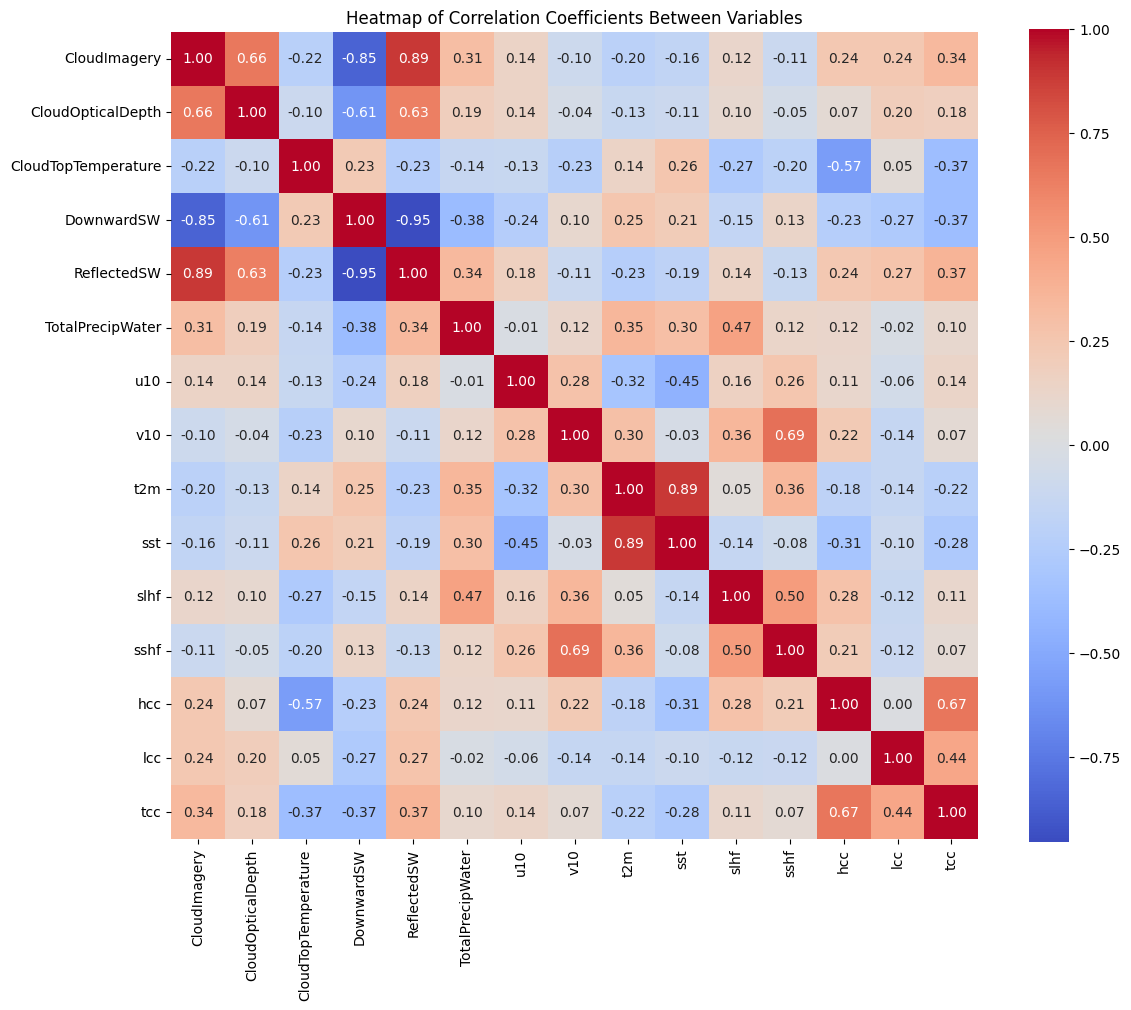

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_dataset is your xarray.Dataset
# Convert the dataset to a Pandas DataFrame and drop missing values
df = cleaned_dataset.to_dataframe().dropna()

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,        # Show correlation coefficients
    fmt=".2f",         # Format coefficients with 2 decimal points
    cmap="coolwarm",   # Color map for heatmap
    cbar=True,         # Show color bar
    square=True        # Make cells square
)
plt.title("Heatmap of Correlation Coefficients Between Variables")
plt.tight_layout()
plt.show()


now we need to print out the highly correlated pairs because i am lazy

In [23]:
import pandas as pd

# Assuming `cleaned_dataset` is your cleaned xarray.Dataset
# Convert to a DataFrame and calculate the correlation matrix
correlation_matrix = cleaned_dataset.to_dataframe().dropna().corr()

# Define a threshold for high correlation
threshold = 0.8

# Find highly correlated variable pairs
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((
                correlation_matrix.index[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# Create a DataFrame for the highly correlated pairs
highly_correlated_pairs_df = pd.DataFrame(
    highly_correlated_pairs, 
    columns=["Variable 1", "Variable 2", "Correlation"]
)

# Display the DataFrame in Jupyter Notebook
from IPython.display import display
display(highly_correlated_pairs_df)



,Variable 1,Variable 2,Correlation
0,CloudImagery,DownwardSW,-0.850602
1,CloudImagery,ReflectedSW,0.887155
2,DownwardSW,ReflectedSW,-0.953273
3,t2m,sst,0.885986


In [24]:
# List of predictor variables
predictor_variables = [
    'ReflectedSW',
    'CloudTopTemperature',
    'CloudOpticalDepth',
    't2m',
    'sst',
    'u10',
    'v10',
    'sshf',
    'slhf',
]

target_variables = ['tcc']

# Select predictors from the xarray dataset
predictors = cleaned_dataset[predictor_variables].to_array().values  # Converts to NumPy array
targets = cleaned_dataset[target_variables].to_array().values  # Cloud fraction as the target


In [25]:
print(f"Predictors shape: {predictors.shape}")  # (time, num_predictors, lat, lon)
print(f"Targets shape: {targets.shape}")        # (time, 1, lat, lon)

Predictors shape: (9, 30, 41, 81)
Targets shape: (1, 30, 41, 81)


In [26]:
# Reshape predictors to (time, channels, lat, lon)
predictors = np.transpose(predictors, (1, 0, 2, 3))  # From (9, 30, 41, 81) to (30, 9, 41, 81)

# Reshape targets to (time, 1, lat, lon)
targets = np.transpose(targets, (1, 0, 2, 3))

print(f"New Predictors shape: {predictors.shape}")  # (30, 9, 41, 81)
print(f"New Targets shape: {targets.shape}")        # (30, 1, 41, 81)

time_steps, channels, lat, lon = predictors.shape

# Flatten lat and lon dimensions
flattened_features = channels * lat * lon
predictors_rnn = predictors.reshape(time_steps, 1, flattened_features)  # Shape: (time_steps, 1, channels * lat * lon)


New Predictors shape: (30, 9, 41, 81)
New Targets shape: (30, 1, 41, 81)


In [27]:
time_steps, _, lat, lon = targets.shape

# Flatten lat and lon dimensions
flattened_targets = lat * lon
targets_rnn = targets.reshape(time_steps, 1, flattened_targets)  # Shape: (time_steps, 1, lat * lon)


In [28]:
print(f"Predictors for RNN shape: {predictors_rnn.shape}")  # Expected: (30, 1, 9 * 41 * 81)
print(f"Targets for RNN shape: {targets_rnn.shape}")        # Expected: (30, 1, 41 * 81)


Predictors for RNN shape: (30, 1, 29889)
Targets for RNN shape: (30, 1, 3321)


In [29]:
# import torch
# import torch.nn as nn

# class CloudFractionRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(CloudFractionRNN, self).__init__()
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, seq_length, input_size)
#         lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, seq_length, hidden_size)
#         output = self.fc(lstm_out)  # Shape: (batch_size, seq_length, output_size)
#         return output

import torch
import torch.nn as nn

class CloudFractionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(CloudFractionRNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0.0)  # Dropout only applies when num_layers > 1
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, seq_length, hidden_size)
        output = self.fc(lstm_out)  # Shape: (batch_size, seq_length, output_size)
        return output



In [30]:
# Dimensions
input_size = predictors_rnn.shape[-1]  # 9 * 41 * 81
hidden_size = 128                      # Number of hidden units (can be tuned)
num_layers = 2                         # Number of LSTM layers
output_size = targets_rnn.shape[-1]    # 41 * 81

# Instantiate the model
model = CloudFractionRNN(input_size, hidden_size, num_layers, output_size)


In [31]:
from torch.utils.data import Dataset, DataLoader

class CloudFractionDataset(Dataset):
    def __init__(self, predictors, targets):
        self.predictors = torch.tensor(predictors, dtype=torch.float32)  # Shape: (time_steps, batch_size, input_size)
        self.targets = torch.tensor(targets, dtype=torch.float32)        # Shape: (time_steps, batch_size, output_size)

    def __len__(self):
        return self.predictors.shape[1]  # Number of sequences (batch_size)

    def __getitem__(self, idx):
        return self.predictors[:, idx, :], self.targets[:, idx, :]  # Return one sequence

# Create the dataset and DataLoader
dataset = CloudFractionDataset(predictors_rnn, targets_rnn)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Batch size of 1 for RNNs


In [32]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for predictors_seq, targets_seq in dataloader:
        predictors_seq = predictors_seq.squeeze(1)  # Remove singleton batch dimension
        targets_seq = targets_seq.squeeze(1)

        optimizer.zero_grad()
        outputs = model(predictors_seq)  # Forward pass
        loss = criterion(outputs, targets_seq)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader)}")


Epoch 1/100, Loss: 0.3954247832298279
Epoch 2/100, Loss: 0.3862791657447815
Epoch 3/100, Loss: 0.37795451283454895
Epoch 4/100, Loss: 0.36859336495399475
Epoch 5/100, Loss: 0.3570883870124817
Epoch 6/100, Loss: 0.34280410408973694
Epoch 7/100, Loss: 0.32551199197769165
Epoch 8/100, Loss: 0.30565589666366577
Epoch 9/100, Loss: 0.2850095331668854
Epoch 10/100, Loss: 0.2676283121109009
Epoch 11/100, Loss: 0.2592264711856842
Epoch 12/100, Loss: 0.25600168108940125
Epoch 13/100, Loss: 0.24882541596889496
Epoch 14/100, Loss: 0.23873409628868103
Epoch 15/100, Loss: 0.22910115122795105
Epoch 16/100, Loss: 0.22198860347270966
Epoch 17/100, Loss: 0.21771006286144257
Epoch 18/100, Loss: 0.21552690863609314
Epoch 19/100, Loss: 0.2144768387079239
Epoch 20/100, Loss: 0.2138313353061676
Epoch 21/100, Loss: 0.2131924033164978
Epoch 22/100, Loss: 0.21242162585258484
Epoch 23/100, Loss: 0.21153375506401062
Epoch 24/100, Loss: 0.2106054127216339
Epoch 25/100, Loss: 0.209708109498024
Epoch 26/100, Loss: 0

In [33]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for predictors_seq, targets_seq in dataloader:
        predictors_seq = predictors_seq.squeeze(1)
        targets_seq = targets_seq.squeeze(1)

        outputs = model(predictors_seq)
        loss = criterion(outputs, targets_seq)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(dataloader)}")


Test Loss: 0.12601438164710999


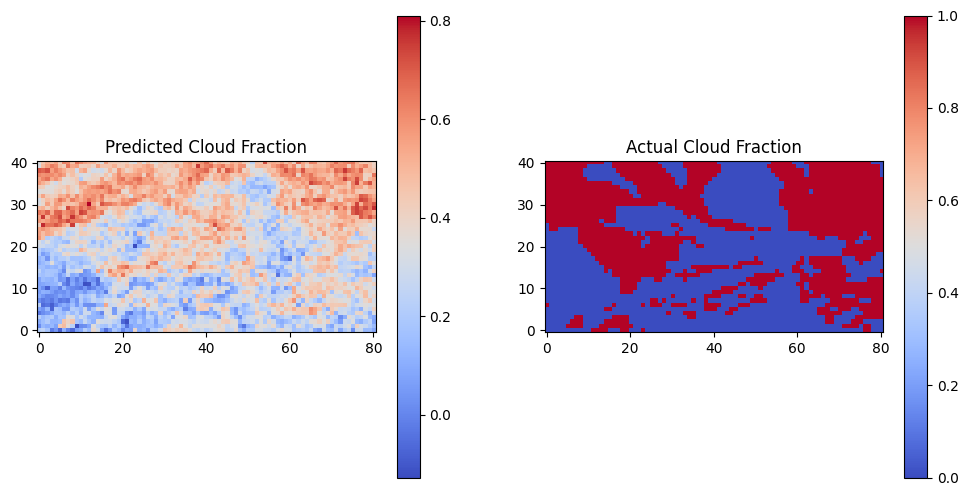

In [34]:
predictions = outputs.reshape(-1, lat, lon).numpy()  # Shape: (time_steps, lat, lon)
actuals = targets_seq.reshape(-1, lat, lon).numpy()  # Shape: (time_steps, lat, lon)

# Visualize a single time step
import matplotlib.pyplot as plt

time_step = 0  # Select a time step
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Predicted Cloud Fraction")
plt.imshow(predictions[time_step], cmap="coolwarm", origin="lower")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Actual Cloud Fraction")
plt.imshow(actuals[time_step], cmap="coolwarm", origin="lower")
plt.colorbar()

plt.show()


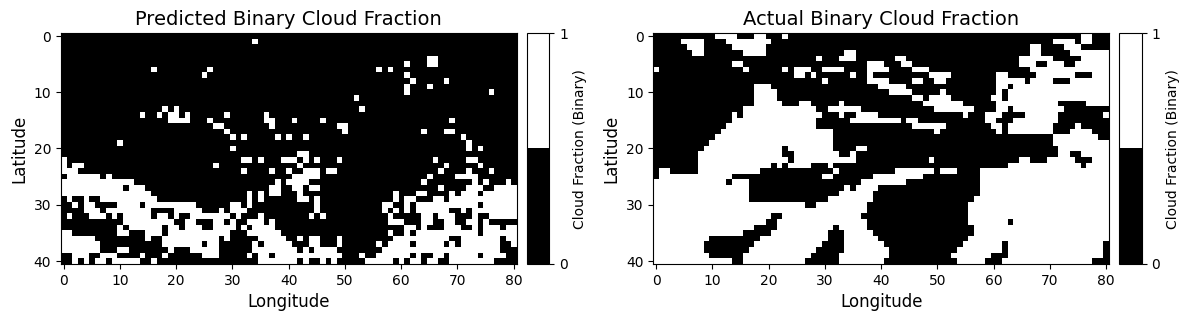

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define a binary colormap (black for 0, white for 1)
binary_cmap = mcolors.ListedColormap(['black', 'white'])

# Apply thresholding to the predictions and actuals
binary_predictions = (predictions >= 0.5).astype(int)
binary_actuals = (actuals >= 0.5).astype(int)

# Visualize a single time step
time_step = 0  # Select a time step to plot

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot predicted binary cloud fraction
ax1 = axes[0]
im_pred = ax1.imshow(binary_predictions[time_step], cmap=binary_cmap)
ax1.set_title("Predicted Binary Cloud Fraction", fontsize=14)
ax1.set_xlabel("Longitude", fontsize=12)
ax1.set_ylabel("Latitude", fontsize=12)

# Add a colorbar for the predicted plot
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im_pred, cax=cax1, ticks=[0, 1]).set_label("Cloud Fraction (Binary)")

# Plot actual binary cloud fraction
ax2 = axes[1]
im_actual = ax2.imshow(binary_actuals[time_step], cmap=binary_cmap)
ax2.set_title("Actual Binary Cloud Fraction", fontsize=14)
ax2.set_xlabel("Longitude", fontsize=12)
ax2.set_ylabel("Latitude", fontsize=12)

# Add a colorbar for the actual plot
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im_actual, cax=cax2, ticks=[0, 1]).set_label("Cloud Fraction (Binary)")

plt.tight_layout()
plt.show()


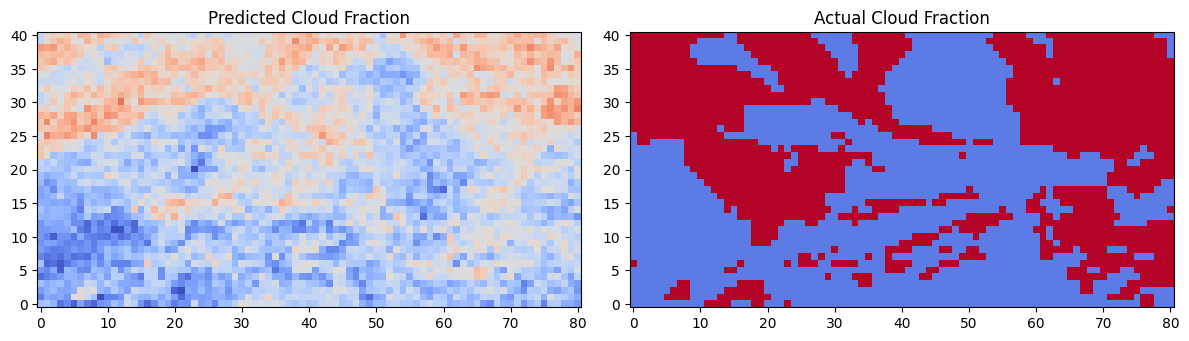

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' and 'actuals' are already defined
time_step = 0  # Select a time step

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define the colormap and normalization to ensure the same scale
vmin = min(predictions[time_step].min(), actuals[time_step].min())
vmax = max(predictions[time_step].max(), actuals[time_step].max())

# Plot the predictions
im1 = axes[0].imshow(predictions[time_step], cmap="coolwarm", origin="lower", vmin=vmin, vmax=vmax)
axes[0].set_title("Predicted Cloud Fraction")

# Plot the actuals
im2 = axes[1].imshow(actuals[time_step], cmap="coolwarm", origin="lower", vmin=vmin, vmax=vmax)
axes[1].set_title("Actual Cloud Fraction")

# Add a single colorbar for the entire figure
# cbar = fig.colorbar(im1, ax=axes, orientation="horizontal", fraction=0.09, pad=0.1)
# cbar.set_label("Cloud Fraction")

plt.tight_layout()
plt.show()


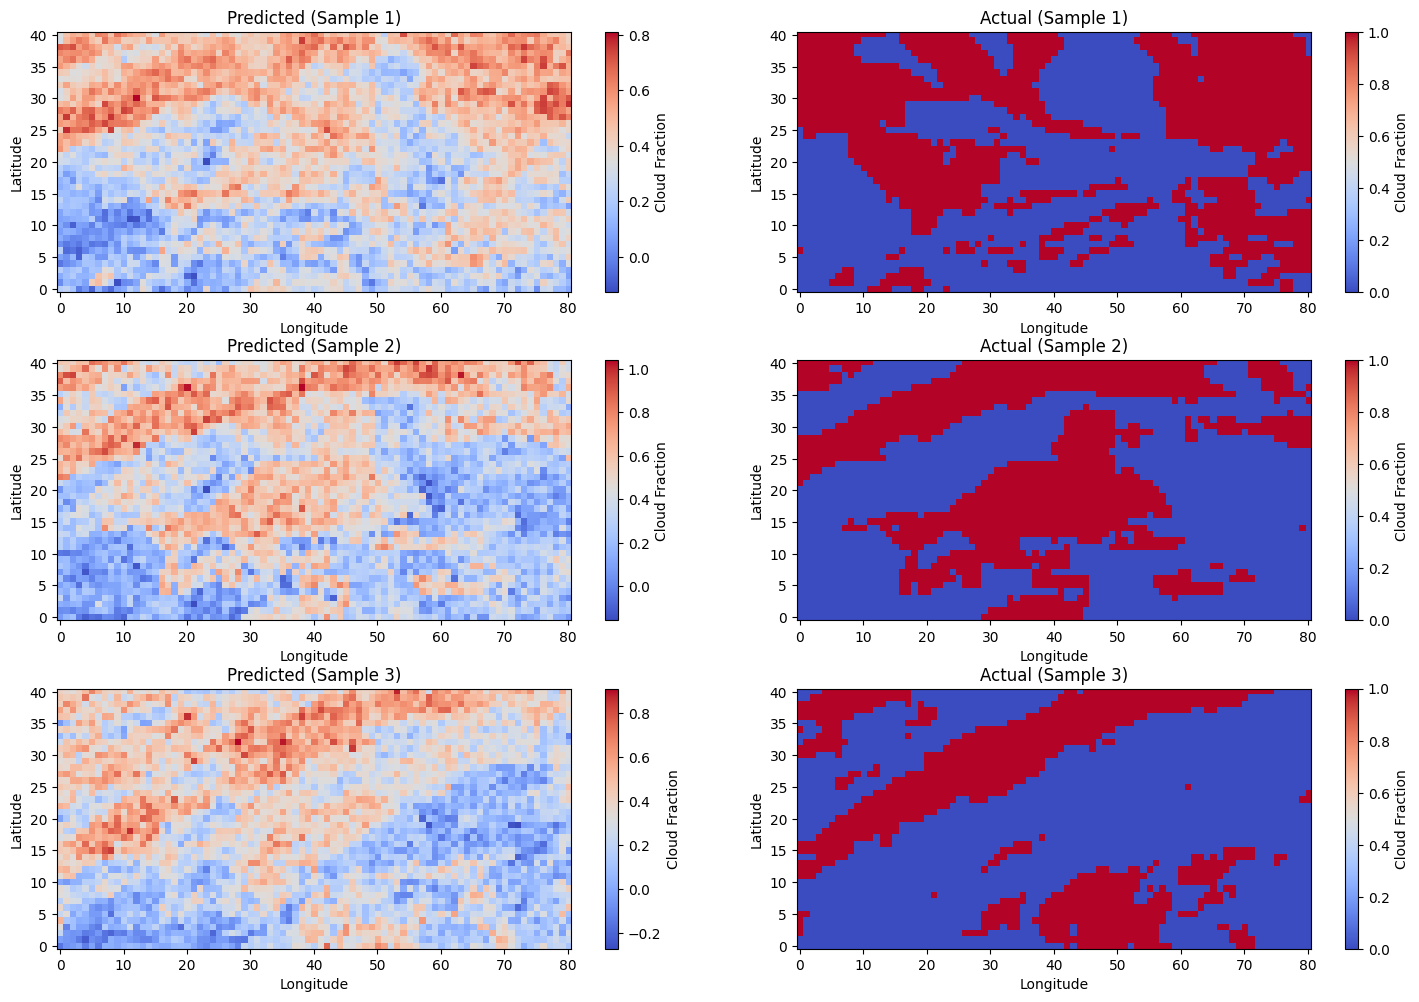

In [37]:
num_samples = 3  # Number of samples to visualize

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    # Predicted map
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.title(f"Predicted (Sample {i+1})")
    plt.imshow(predictions[i], cmap="coolwarm", origin="lower")
    plt.colorbar(label="Cloud Fraction")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Actual map
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.title(f"Actual (Sample {i+1})")
    plt.imshow(actuals[i], cmap="coolwarm", origin="lower")
    plt.colorbar(label="Cloud Fraction")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

plt.tight_layout()
plt.show()


i dont have the computational power to try a custom loss function or the augnmenting data, when i tried my kernel kept dying immediately.

In [38]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Initialize accumulators for true/false positives and negatives
all_targets = []
all_predictions = []

# Evaluation loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for predictors_seq, targets_seq in dataloader:
        predictors_seq = predictors_seq.squeeze(1)
        targets_seq = targets_seq.squeeze(1)

        outputs = model(predictors_seq)
        loss = criterion(outputs, targets_seq)
        test_loss += loss.item()

        # Convert model outputs to binary predictions
        binary_outputs = (outputs >= 0.5).int()

        # Collect predictions and targets
        all_predictions.append(binary_outputs.cpu().numpy().flatten())
        all_targets.append(targets_seq.cpu().numpy().flatten())

# Calculate overall test loss
print(f"Test Loss: {test_loss / len(dataloader)}")

# Flatten all collected predictions and targets
all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(all_targets, all_predictions).ravel()

# Calculate accuracy
accuracy = accuracy_score(all_targets, all_predictions)

# Print results
print(f"Confusion Matrix: \nTP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
print(f"Accuracy: {accuracy:.2f}")

# Display as a table
import pandas as pd

results_table = pd.DataFrame({
    "Metric": ["True Positives", "False Positives", "True Negatives", "False Negatives", "Accuracy"],
    "Value": [tp, fp, tn, fn, accuracy]
})
print(results_table)


Test Loss: 0.12601438164710999
Confusion Matrix: 
TP: 28088, FP: 6473, TN: 54455, FN: 10614
Accuracy: 0.83
            Metric         Value
0   True Positives  28088.000000
1  False Positives   6473.000000
2   True Negatives  54455.000000
3  False Negatives  10614.000000
4         Accuracy      0.828495


In [39]:
import itertools

# Define hyperparameter grid
learning_rates = [0.001, 0.0001, 0.01]
hidden_sizes = [64, 128, 256]
num_layers_options = [1, 2, 3]
batch_sizes = [1, 8, 16]

# List to store results
results = []

# Iterate through combinations of hyperparameters
for lr, hidden_size, num_layers, batch_size in itertools.product(learning_rates, hidden_sizes, num_layers_options, batch_sizes):
    print(f"Testing with lr={lr}, hidden_size={hidden_size}, num_layers={num_layers}, batch_size={batch_size}")

    # Define model
    model = CloudFractionRNN(input_size, hidden_size, num_layers, output_size)
    
    # Define optimizer and dataloader
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Train model for a few epochs
    num_epochs = 10  # Short for initial testing
    avg_loss = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for predictors_seq, targets_seq in dataloader:
            predictors_seq = predictors_seq.squeeze(1)
            targets_seq = targets_seq.squeeze(1)

            optimizer.zero_grad()
            outputs = model(predictors_seq)
            loss = criterion(outputs, targets_seq)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss += running_loss / len(dataloader)
    avg_loss /= num_epochs

    # Store result
    results.append({'lr': lr, 'hidden_size': hidden_size, 'num_layers': num_layers, 
                    'batch_size': batch_size, 'avg_loss': avg_loss})

# Print and sort results
results = sorted(results, key=lambda x: x['avg_loss'])
for r in results:
    print(r)


Testing with lr=0.001, hidden_size=64, num_layers=1, batch_size=1
Testing with lr=0.001, hidden_size=64, num_layers=1, batch_size=8
Testing with lr=0.001, hidden_size=64, num_layers=1, batch_size=16
Testing with lr=0.001, hidden_size=64, num_layers=2, batch_size=1
Testing with lr=0.001, hidden_size=64, num_layers=2, batch_size=8
Testing with lr=0.001, hidden_size=64, num_layers=2, batch_size=16
Testing with lr=0.001, hidden_size=64, num_layers=3, batch_size=1
Testing with lr=0.001, hidden_size=64, num_layers=3, batch_size=8
Testing with lr=0.001, hidden_size=64, num_layers=3, batch_size=16
Testing with lr=0.001, hidden_size=128, num_layers=1, batch_size=1
Testing with lr=0.001, hidden_size=128, num_layers=1, batch_size=8
Testing with lr=0.001, hidden_size=128, num_layers=1, batch_size=16
Testing with lr=0.001, hidden_size=128, num_layers=2, batch_size=1
Testing with lr=0.001, hidden_size=128, num_layers=2, batch_size=8
Testing with lr=0.001, hidden_size=128, num_layers=2, batch_size=16

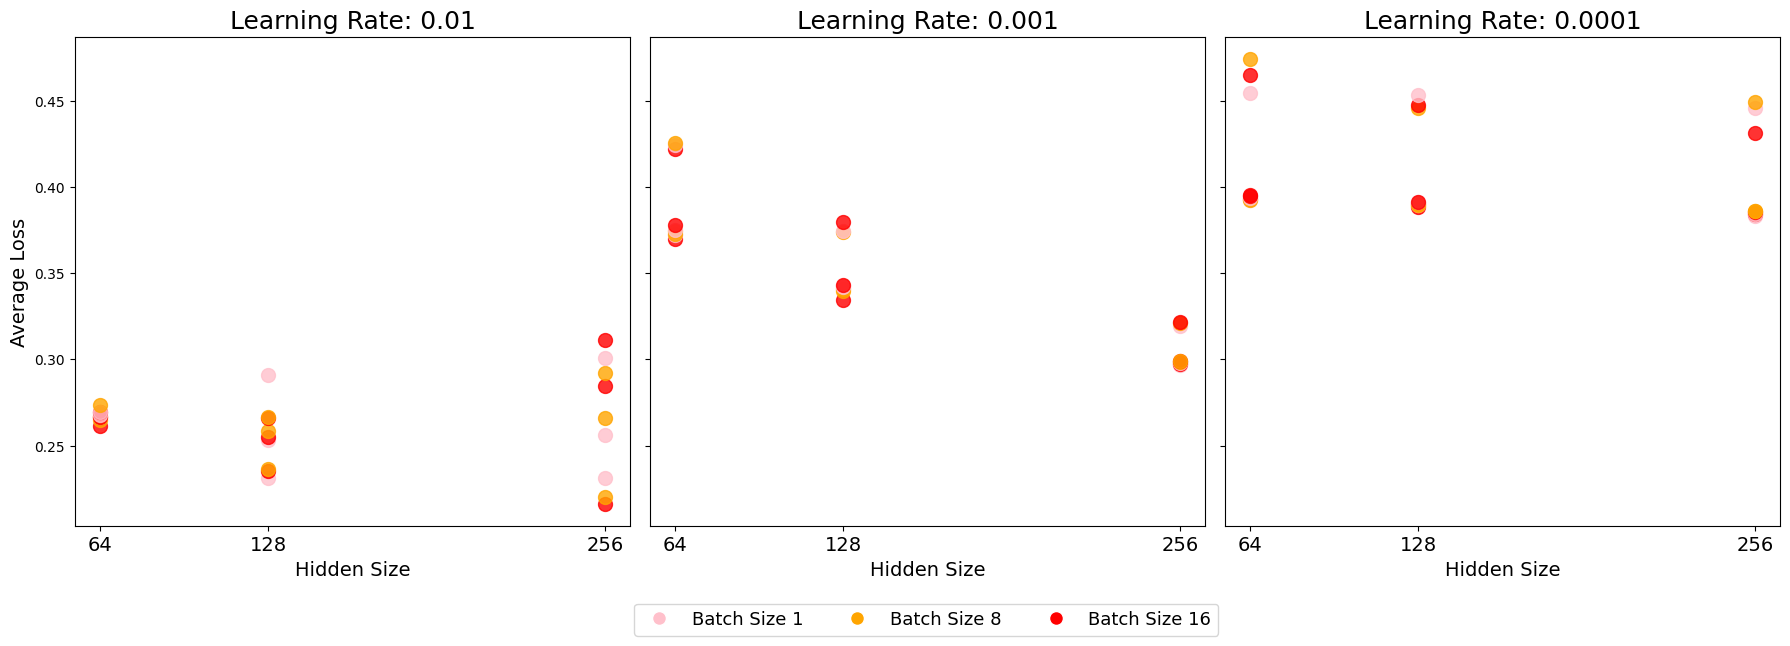

In [40]:
# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Define a color mapping for batch sizes
batch_size_colors = {1: 'pink', 8: 'orange', 16: 'red'}

# Create subplots for each learning rate
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Get unique learning rates
learning_rates = df_results['lr'].unique()

# Loop through learning rates and plot on separate subplots
for i, lr in enumerate(learning_rates):
    ax = axs[i]
    lr_data = df_results[df_results['lr'] == lr]
    
    # Plot each point with its respective color
    for _, row in lr_data.iterrows():
        ax.scatter(
            row['hidden_size'],
            row['avg_loss'],
            color=batch_size_colors[row['batch_size']],
            s=100,
            alpha=0.8
        )
    
    ax.set_title(f"Learning Rate: {lr}", fontsize=18)
    ax.set_xlabel("Hidden Size", fontsize=14)
    if i == 0:  # Add ylabel only on the first subplot
        ax.set_ylabel("Average Loss", fontsize=14)
    ax.set_xticks(lr_data['hidden_size'].unique())
    ax.set_xticklabels(lr_data['hidden_size'].unique(), fontsize=14)

    
# Add a legend for batch sizes
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"Batch Size {size}")
                  for size, color in batch_size_colors.items()]
fig.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(0.35, 0.0), ncol=3, fontsize=13)

plt.tight_layout()
plt.show()


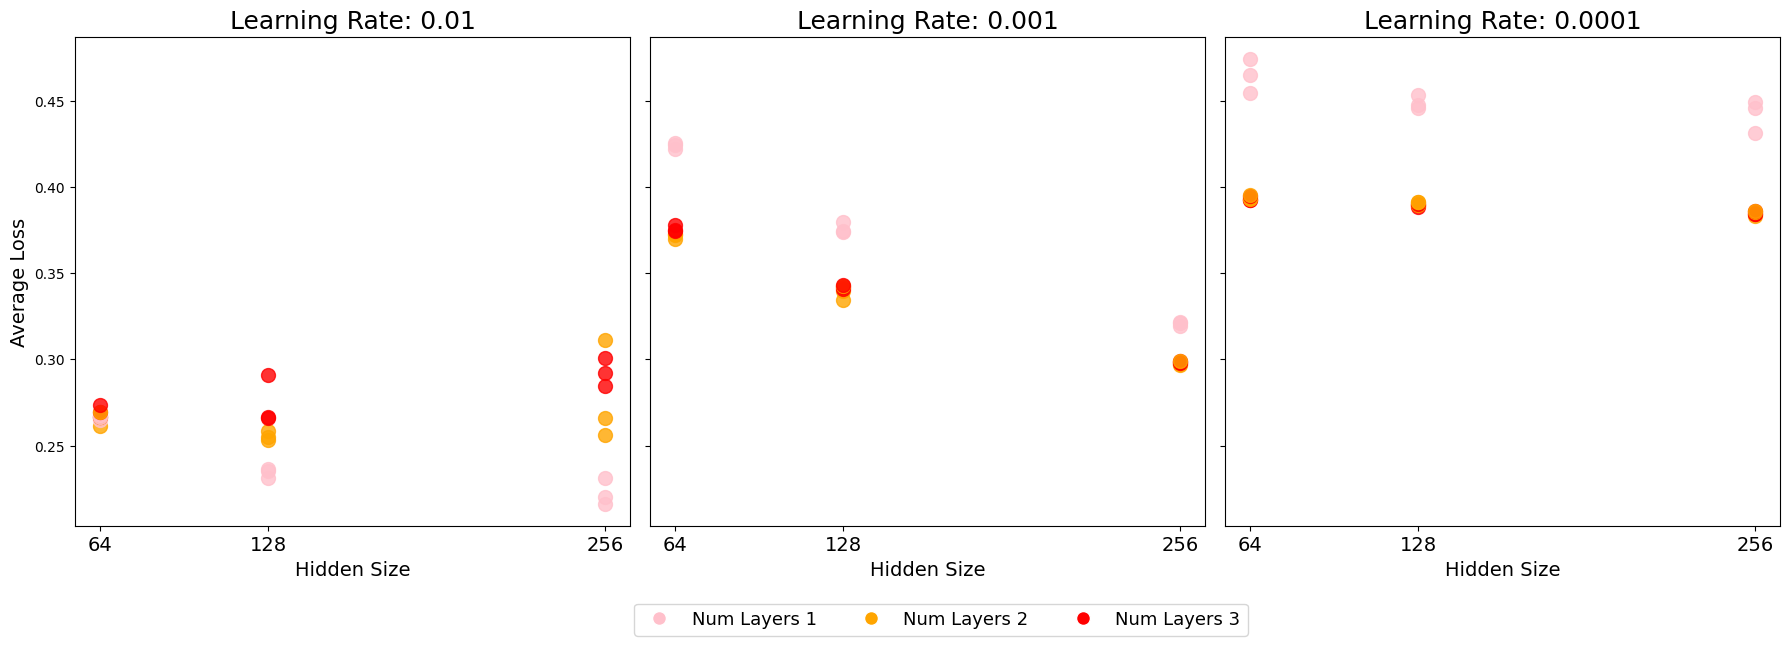

In [41]:
# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Define a color mapping for batch sizes
num_layers_colors = {1: 'pink', 2: 'orange', 3: 'red'}

# Create subplots for each learning rate
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Get unique learning rates
learning_rates = df_results['lr'].unique()

# Loop through learning rates and plot on separate subplots
for i, lr in enumerate(learning_rates):
    ax = axs[i]
    lr_data = df_results[df_results['lr'] == lr]
    
    # Plot each point with its respective color
    for _, row in lr_data.iterrows():
        ax.scatter(
            row['hidden_size'],
            row['avg_loss'],
            color=num_layers_colors[row['num_layers']],
            s=100,
            alpha=0.8
        )
    
    ax.set_title(f"Learning Rate: {lr}", fontsize=18)
    ax.set_xlabel("Hidden Size", fontsize=14)
    if i == 0:  # Add ylabel only on the first subplot
        ax.set_ylabel("Average Loss", fontsize=14)
    ax.set_xticks(lr_data['hidden_size'].unique())
    ax.set_xticklabels(lr_data['hidden_size'].unique(), fontsize=14)

    
# Add a legend for batch sizes
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"Num Layers {size}")
                  for size, color in num_layers_colors.items()]
fig.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(0.35, 0.0), ncol=3, fontsize=13)

plt.tight_layout()
plt.show()
